In [1]:
import numpy as np

from itertools import chain

import sklearn
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from joblib import dump, load

In [2]:
# extract label of each token         
def extractNEs(filename, data):
    texts = []
    infile = open(filename, "r", encoding="utf-8-sig")
    lines = infile.readlines()
    
    # loop through each token
    for line in lines:
        if line.strip("\n"):
            word,pos,label = line.strip("\n").split('\t')
            texts.append((word,pos,label))
        else: # end of sentence
            data.append(texts)
            texts = []
    infile.close()

In [3]:
def containDigit(token):
    return any(char.isdigit() for char in token)

def isPercent(token):
    if '%' in token or 'yüzde' in token or 'binde' in token or 'onda' in token:
        return True
    return False

def isTime(token):
    if 'saat' in token:
        return True
    ########################
    elif ':' in token:
        splittedWord = token.split(':')
        if containDigit(splittedWord[0]) and containDigit(splittedWord[1]):
            return True
    #######################
    return False

def checkCase(token):
    if token.islower():
        return 0
    elif token.isupper():
        return 1
    elif token.istitle():
        return 2
    else:
        return 3   
    
def word2features(doc, i):
    word = doc[i][0]
    postag = doc[i][1]

    # Common features for all words
    features = [
        'bias',
        'word.lower=%s' % word.lower(),
        'word[-3:]=%s' % word[-3:],
        'word[-4:]=%s' % word[-4:],
        'word[:4]=%s' % word[:4],
        'word[:5]=%s' % word[:5],
        'word.case=%s' % checkCase(word),
        'word.isnumeric=%s' % word.isnumeric(),
        'word.containDigit=%s' % containDigit(word),
        'postag=%s' % postag,
        'word.isPercent=%s' % isPercent(word),
        'word.isTime=%s' % isTime(word)
    ]

    # Features for words that are not
    # at the beginning of a document
    if i > 1:
        word = doc[i-2][0]
        postag = doc[i-2][1]
        
        features.extend([
            '-2:word.lower=%s' % word.lower(),
            '-2:word[-3:]=%s' % word[-3:],
            '-2:word[-4:]=%s' % word[-4:],
            '-2:word[:4]=%s' % word[:4],
            '-2:word[:5]=%s' % word[:5],
            '-2:word.case=%s' % checkCase(word),
            '-2:word.isnumeric=%s' % word.isnumeric(),
            '-2:word.containDigit=%s' % containDigit(word),
            '-2:postag=%s' % postag,
            '-2:word.isPercent=%s' % isPercent(word),
            '-2:word.isTime=%s' % isTime(word)
        ])
        
    if i > 0:
        word = doc[i-1][0]
        postag = doc[i-1][1]
        
        features.extend([
            '-1:word.lower=%s' + word.lower(),
            '-1:word[-3:]=%s' % word[-3:],
            '-1:word[-4:]=%s' % word[-4:],
            '-1:word[:4]=%s' % word[:4],
            '-1:word[:5]=%s' % word[:5],
            '-1:word.case=%s' % checkCase(word),
            '-1:word.isnumeric=%s' % word.isnumeric(),
            '-1:word.containDigit=%s' % containDigit(word),
            '-1:postag=%s' % postag,
            '-1:word.isPercent=%s' % isPercent(word),
            '-1:word.isTime=%s' % isTime(word)
        ])
        
    else:
        # Indicate that it is the 'beginning of a document'
        features.append('BOS')

    # Features for words that are not
    # at the end of a document
    
    if i < len(doc)-2:
        word = doc[i+2][0]
        postag = doc[i+2][1]     
        
        features.extend([
            '+2:word.lower=%s' % word.lower(),
            '+2:word[-3:]=%s' % word[-3:],
            '+2:word[-4:]=%s' % word[-4:],
            '+2:word[:4]=%s' % word[:4],
            '+2:word[:5]=%s' % word[:5],
            '+2:word.case=%s' % checkCase(word),
            '+2:word.isnumeric=%s' % word.isnumeric(),
            '+2:word.containDigit=%s' % containDigit(word),
            '+2:postag=%s' % postag,
            '+2:word.isPercent=%s' % isPercent(word),
            '+2:word.isTime=%s' % isTime(word)
        ])      
    
    if i < len(doc)-1:
        word = doc[i+1][0]
        postag = doc[i+1][1]
       
        features.extend([
            '+1:word.lower=%s' + word.lower(),
            '+1:word[-3:]=%s' % word[-3:],
            '+1:word[-4:]=%s' % word[-4:],
            '+1:word[:4]=%s' % word[:4],
            '+1:word[:5]=%s' % word[:5],
            '+1:word.case=%s' % checkCase(word),
            '+1:word.isnumeric=%s' % word.isnumeric(),
            '+1:word.containDigit=%s' % containDigit(word),
            '+1:postag=%s' % postag,
            '+1:word.isPercent=%s' % isPercent(word),
            '+1:word.isTime=%s' % isTime(word)
        ])  
        
    else:
        # Indicate that it is the 'end of a document'
        features.append('EOS')

    return features

In [4]:
# A function for extracting features in documents
def extract_features(sentence):
    return [word2features(sentence, tokenIndex) for tokenIndex in range(len(sentence))]

# A function fo generating the list of labels for each document
def get_labels(sentence):
    return [label for (token, postag, label) in sentence]

In [5]:
def runCRF(X_train, y_train):
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs', 
        c1=0.1, 
        c2=0.01, 
        max_iterations=100, 
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)
    
    return crf

In [6]:
def calculateF1Score(y_test, y_pred):
    metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

    sorted_labels = sorted(
        labels, 
        key=lambda name: (name[1:], name[0])
    )
    print(metrics.flat_classification_report(
        y_test, y_pred, labels=sorted_labels, digits=3
    ))

# First Option: 10-Fold Cross Validation

In [ ]:
# extract training dataset
data = []
extractNEs("data/train.txt", data)

X = [extract_features(sentence) for sentence in data]
y = [get_labels(sentence) for sentence in data]

In [ ]:
%%time
from sklearn.model_selection import KFold

X = np.array(X)
y = np.array(y)
# prepare cross validation
kfold = KFold(10, True, 1)
j = 1
# enumerate splits
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    crf = runCRF(X_train, y_train)

    labels = list(crf.classes_)
    labels.remove('O')

    y_pred = crf.predict(X_test)
    
    calculateF1Score(y_test, y_pred)
    
    filename = str(j) + ".fold.txt"
    j = j+1
    
    file = open(filename, "w", encoding="utf-8")
    for i in range(len(X_test)):
        for label, pred, word in zip(y_test[i], y_pred[i], [x[1].split("=")[1] for x in X_test[i]]):
            s = "%s\t%s\t%s\n" % (word, pred, label)
            file.write(s)
        file.write("\n")
    file.close()
    

# Second Option: Use Train & Test Datasets

In [7]:
# extract training dataset
data = []
extractNEs("data/train.txt", data)

X_train = [extract_features(sentence) for sentence in data]
y_train = [get_labels(sentence) for sentence in data]

In [9]:
crf = runCRF(X_train, y_train)

# Save & Load The Model

In [9]:
#SAVE THE MODEL
dump(crf, 'crf.joblib') 

['crf.joblib']

In [11]:
#LOAD THE MODEL
crf = load('crf.joblib') 

In [8]:
# extract test dataset
test_data = []
extractNEs("data/test.txt", test_data)

X_test = [extract_features(sentence) for sentence in test_data]
y_test = [get_labels(sentence) for sentence in test_data]

In [10]:
labels = list(crf.classes_)
labels.remove('O')

y_pred = crf.predict(X_test)

calculateF1Score(y_test, y_pred)

              precision    recall  f1-score   support

        DATE      0.853     0.873     0.863       259
     PERCENT      0.965     0.887     0.924       124
      PERSON      0.918     0.907     0.912      1019
        TIME      0.941     1.000     0.970        32
    LOCATION      0.970     0.921     0.945       732
       MONEY      1.000     0.937     0.967       127
ORGANIZATION      0.969     0.872     0.918       822

   micro avg      0.942     0.900     0.920      3115
   macro avg      0.945     0.914     0.928      3115
weighted avg      0.943     0.900     0.921      3115



# HYPERPARAMETER OPTIMIZATION

In [11]:
%%time
# HYPERPARAMETER OPTIMIZATION
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 126.2min finished


CPU times: user 2h 2min, sys: 4min 10s, total: 2h 6min 11s
Wall time: 2h 7min 50s


In [12]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.13468476285586248, 'c2': 0.03379284804608451}
best CV score: 0.8848701730194322
model size: 5.11M


Dark blue => 0.8623, dark red => 0.8849


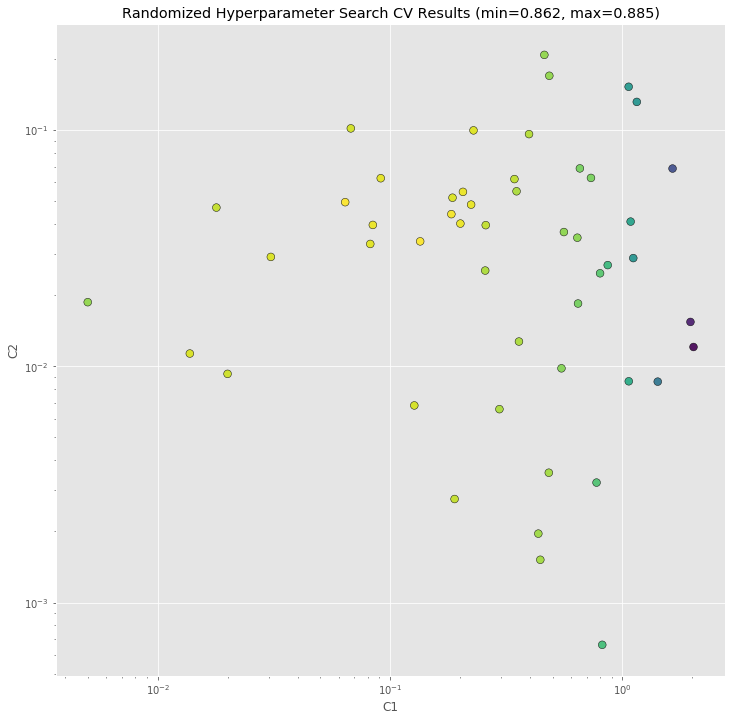

In [14]:
# Check parameter space
#_x = [s.parameters['c1'] for s in rs.grid_scores_]
_x = [s.get('c1') for s in rs.cv_results_["params"]]
#_y = [s.parameters['c2'] for s in rs.grid_scores_]
_y = [s.get('c2') for s in rs.cv_results_["params"]]
#_c = [s.mean_validation_score for s in rs.grid_scores_]
_c = [s for s in rs.cv_results_["mean_test_score"]]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [16]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
calculateF1Score(y_test, y_pred)

              precision    recall  f1-score   support

        DATE      0.880     0.846     0.862       259
     PERCENT      0.965     0.887     0.924       124
      PERSON      0.924     0.909     0.916      1019
        TIME      0.914     1.000     0.955        32
    LOCATION      0.967     0.915     0.940       732
       MONEY      1.000     0.929     0.963       127
ORGANIZATION      0.964     0.872     0.916       822

   micro avg      0.945     0.896     0.920      3115
   macro avg      0.945     0.908     0.925      3115
weighted avg      0.946     0.896     0.920      3115

